# <u>**CASE STUDY1</u> - HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS**

![picture](https://drive.google.com/uc?id=1pLkGbp71slHrg7xgfVG4_T3r0-AbJhJP)

This notebook contains:-
1. Best Model obtained after training the entire datasets with different models.
2. Important Features obtained from best model.
2. Conclusion about the best model and its features.

<u>Note</u>: 

Source of dataset: [Kaggle](https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis)

Business aspect of features: [Features](https://docs.google.com/spreadsheets/d/1yaYsMDEV96UvKvwfsYLk3VnSf7u1po9MQFE_j3Y9kkI/edit?usp=share_link)


## <b>Notebook Content</b>

>[CASE STUDY1 - HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS](#scrollTo=fJtCtVE24yIt)

>>[Notebook Content](#scrollTo=fJtCtVE24yIt)

>>[Loading Packages/Libraries](#scrollTo=6z4JL9uMBdKH)

>>[Loading Data](#scrollTo=EK2NqYAgBjDS)

>>>[2.1 Splitting and scaling data into Train and Cross Validation(or Test)](#scrollTo=EK2NqYAgBjDS)

>>>>[2.1.1 Stratified Sampling(70:30)](#scrollTo=EK2NqYAgBjDS)

>>[Functions Required for Training the Best Model](#scrollTo=25MhbOiDBrh1)

>>>[3.4 Logistic Regression with random state = 49](#scrollTo=-sMu5-o7FE0E)

>>>>[3.4.1 Most important features using Logistic Regression with random state = 49](#scrollTo=ymKissL_G_LH)

>>>>[3.4.2 Least important features using Logistic Regression with random state = 49](#scrollTo=My6lfDf7HDxp)

>>>>[3.4.3 Summary of results](#scrollTo=6PxnGyBkIINo)

>>[Store the best model as .pkl file](#scrollTo=nITWLNtcIenS)

>>[Conclusion from Best Model](#scrollTo=sXHjpzxwI5z2)



## 1. Loading Packages/Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt 

import math
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from prettytable import PrettyTable
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## 2. Loading Data
### 2.1 Splitting and scaling data into Train and Cross Validation(or Test)
#### 2.1.1 Stratified Sampling(70:30)

In [2]:
train_df = pd.read_csv('Final_train1.csv')
cv_df = pd.read_csv('Final_cv1.csv')

X_train_std = train_df.drop(axis=1, columns=['PotentialFraud'])             # drop potential fraud column from X_train
y_train = train_df['PotentialFraud']                                        # use potential fraud column as Y_train

X_cv_std = cv_df.drop(axis=1, columns=['PotentialFraud'])                   # drop potential fraud column from X_cv
y_cv = cv_df['PotentialFraud']                                              # use potential fraud column as Y_cv


print('X_train Shape = ', X_train_std.shape, '\nX_cv Shape = ', X_cv_std.shape, '\nY_train Shape = ',  y_train.shape, '\nY_cv Shape = ', y_cv.shape)

y_trn = y_train.to_numpy()
y_cvl = y_cv.to_numpy()

X_train Shape =  (3787, 50) 
X_cv Shape =  (1623, 50) 
Y_train Shape =  (3787,) 
Y_cv Shape =  (1623,)


## 3. Functions Required for Training the Best Model

In [3]:
def pred_proba(clf, data):
  '''Function takes classifier and train/cv data and returns the predicted probability'''
  y_pred = clf.predict_proba(data)[:,1]                                               # predict probability of Class 1

  return y_pred

def find_best_threshold(threshould, fpr, tpr):
    '''Calculates threshold with max value of exp: tpr(1-fpr)'''
    t = threshould[np.argmax(tpr*(1-fpr))]                                            # (tpr*(1-fpr)) = maximum if fpr = very low and tpr = very high

    return t

def predict_with_best_t(proba, threshould):
    '''Calculates predicted probability for best threshold'''
    predictions = []
    for i in proba:
        if i>=threshould:                                                             # predict 1 if above threshold
            predictions.append(1)                                                     # store value in list
        else:                                                                         # predict 0 if below threshold
            predictions.append(0)                                                     # store value in list
    return predictions

def plot_confusion_matrix(best_t, x_tr, x_cv, y_tr, y_cv, y_tr_pred, y_cv_pred):
    '''Function takes best threshold, train/cv data and predicted train/cv data and returns train/cv predictions along with the confusion matrix'''
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    cm = confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t))               # Calculate count of the confusion matrix for Train Data
    with plt.style.context('seaborn'):                                                # Set the background for graph plotting 
      sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='YlGnBu')                   # Plot Heatmap of Train Confusion Matrix
      ax[0].set_title('Train Confusion Matrix')                                       # Add title of the plot
      ax[0].set_xlabel('Predicted Values')                                            # Add label to x-axis
      ax[0].set_ylabel('Actual Values')                                               # Add label to y-axis
    
    cm = confusion_matrix(y_cv, predict_with_best_t(y_cv_pred, best_t))               # Calculate count of the confusion matrix for CV Data
    with plt.style.context('seaborn'):                                                # Set the background for graph plotting 
      sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='YlGnBu')                   # Plot Heatmap of CV Confusion Matrix
      ax[1].set_title('CV Confusion Matrix')                                          # Add title of the plot
      ax[1].set_xlabel('Predicted Values')                                            # Add label to x-axis
      ax[1].set_ylabel('Actual Values')                                               # Add label to x-axis
        
    plt.show()
    
    return predict_with_best_t(y_tr_pred, best_t), predict_with_best_t(y_cv_pred, best_t)

def model_validation(clf, x_tr, x_cv, y_tr, y_cv):
  '''Function takes classifier, train and cv data and returns the best threshhold, model auc and train/cv f1 score'''
  y_tr_pred = pred_proba(clf, x_tr)                                                   # function call
  y_cv_pred = pred_proba(clf, x_cv)                                                   # function call
  train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_tr_pred)                    # Calculate FPR and TPR for Train Data
  cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv, y_cv_pred)                          # Calculate FPR and TPR for CV Data

  print('Train AUC = {}'.format(auc(train_fpr, train_tpr)))
  print('CV AUC = {}'.format(auc(cv_fpr, cv_tpr)))

  plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr))) # Plot Train FPR and Train TPR
  plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))                # Plot CV FPR and CV TPR
  plt.legend()                                                                       # Add legend to the plot
  plt.plot([0,1],[0,1], 'g-')                                                        # Plot a diagnol for random model
  plt.xlabel("False positive Rate(FPR)")                                             # Add label to x-axis
  plt.ylabel("True positive Rate(TPR)")                                              # Add label to y-axis
  plt.title("ROC Curve")                                                             # Add title of the plot
  plt.grid()                                                                         # Add grid to the plot
  plt.show()

  best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)                  # function call
  tr_pred, cv_pred = plot_confusion_matrix(best_t, x_tr, x_cv, y_tr, y_cv, y_tr_pred, y_cv_pred)
  train_f1_score = f1_score(y_tr, tr_pred)                                           # calculate Train F1 score
  cv_f1_score = f1_score(y_cv, cv_pred)                                              # calculate cv F1 score

  return best_t, auc(cv_fpr, cv_tpr), train_f1_score, cv_f1_score

def imp_features(imp_feat, feat_weights, val, head):
  '''Function to predict the important features after applying a classification model on it'''
  feat_imp = pd.DataFrame(list(zip(imp_feat, feat_weights)), columns =['Features', 'Weights'])
  feat_imp = feat_imp[feat_imp['Weights'] != 0]                                     # Filter non zero weights of features with names
  feat_imp.reset_index(drop=True, inplace=True)

  best_worst_15_feat = feat_imp.sort_values(by= 'Weights',ascending=val)['Features'].iloc[0:15]
  best_worst_15_feat_weights = feat_imp.sort_values(by='Weights',ascending=val)['Weights'].iloc[0:15]
  feat_list = pd.DataFrame(list(zip(list(best_worst_15_feat), list(best_worst_15_feat_weights))), columns =['Features', 'Weights'])
  print(feat_list.head(15))

  with plt.style.context('seaborn-white'):                                          # Set the white background for graph plotting 
    plt.figure(figsize=(12, 8))
    sns.barplot(y=best_worst_15_feat, x=best_worst_15_feat_weights)                 # Bargraph with features and its weights
    plt.grid(linestyle="-")                                                         # Add grid to the plot
    plt.xlabel('Features Importance Weights')                                       # Add label to x-axis
    plt.ylabel('Features')                                                          # Add label to y-axis
    plt.title(head + 'Features')                                                    # Add title of the plot

  plt.show()

### 3.4 Logistic Regression with random state = 49

Train AUC = 0.9405512465419549
CV AUC = 0.9532094171526709


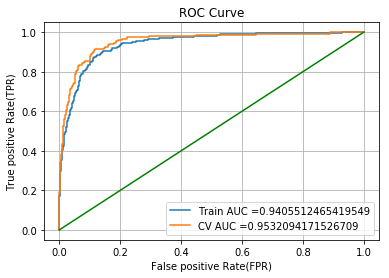

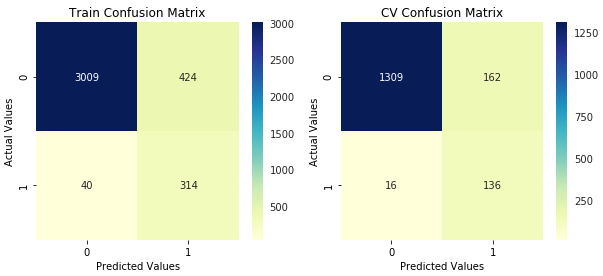

Best Threshold = 0.3709
Model AUC = 0.9532
Train F1 Score = 0.5751
CV F1 Score = 0.6044


In [4]:
model3 = LogisticRegression(penalty='l2',
                            C=0.4430621,
                            tol=0.0001,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=49,
                            solver='liblinear',  
                            max_iter=500)

model3.fit(X_train_std, y_train)

best_t, model_auc, train_f1_score, cv_f1_score = model_validation(model3, X_train_std, X_cv_std, y_train, y_cv)         # function call
print('Best Threshold = {:.4f}'.format(best_t))
print('Model AUC = {:.4f}'.format(model_auc))
print('Train F1 Score = {:.4f}'.format(train_f1_score))
print('CV F1 Score = {:.4f}'.format(cv_f1_score))

#### 3.4.1 Most important features using Logistic Regression with random state = 49

                                             Features   Weights
0   mean_InscClaimAmtReimbursed_perOperatingPhysician  2.633486
1            mean_Hospital_Days_perAttendingPhysician  1.704703
2                     count_ClaimID_perProviderBeneID  1.657598
3       mean_InscClaimAmtReimbursed_perOtherPhysician  1.090961
4                         mean_Claim_Days_perProvider  0.995610
5                               RenalDiseaseIndicator  0.838229
6            mean_Hospital_Days_perOperatingPhysician  0.689480
7            mean_Hospital_Days_perClmDiagnosisCode_5  0.620868
8            mean_DeductibleAmtPaid_perOtherPhysician  0.604518
9            mean_Hospital_Days_perClmDiagnosisCode_9  0.580291
10           mean_Hospital_Days_perClmDiagnosisCode_8  0.494931
11        count_ClaimID_perProviderClmDiagnosisCode_4  0.485881
12            count_ClaimID_perProviderOtherPhysician  0.429020
13           mean_Hospital_Days_perClmDiagnosisCode_2  0.410700
14                                      

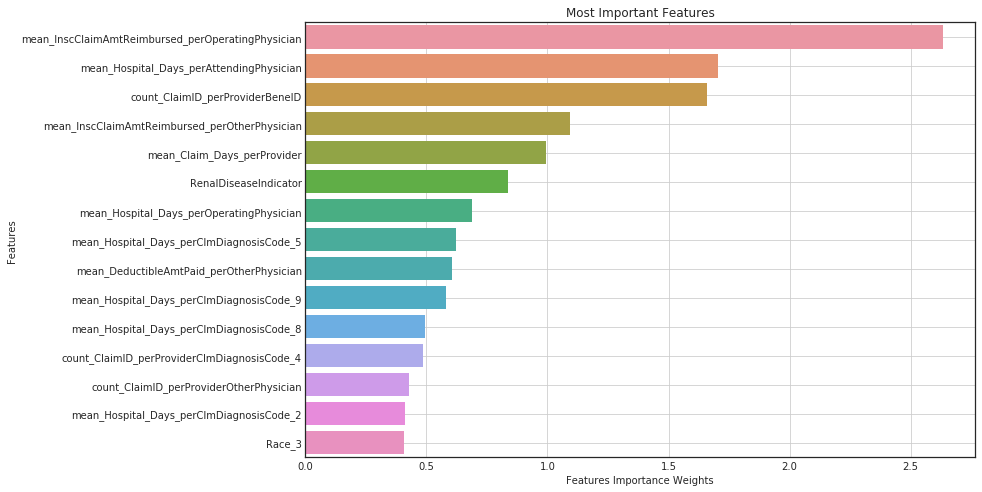

In [5]:
feat_weights = list(model3.coef_[0])
imp_feat = X_train_std.columns

imp_features(imp_feat, feat_weights, False, 'Most Important ')             # function call

#### 3.4.2 Least important features using Logistic Regression with random state = 49

                                             Features   Weights
0            mean_Hospital_Days_perClmDiagnosisCode_3 -1.329666
1                   mean_Claim_Days_perOtherPhysician -1.322850
2                    mean_DeductibleAmtPaid_perBeneID -0.863484
3                mean_Hospital_Days_perOtherPhysician -0.858212
4                               ChronicCond_Alzheimer -0.802235
5               mean_Claim_Days_perClmDiagnosisCode_1 -0.736349
6        mean_DeductibleAmtPaid_perOperatingPhysician -0.638207
7            mean_Hospital_Days_perClmDiagnosisCode_4 -0.527985
8            mean_Hospital_Days_perClmProcedureCode_1 -0.517320
9                           mean_Claim_Days_perBeneID -0.508628
10          mean_Hospital_Days_perClmDiagnosisCode_10 -0.368669
11  mean_InscClaimAmtReimbursed_perClmDiagnosisCode_4 -0.361220
12  mean_IPAnnualReimbursementAmt_perClmDiagnosisC... -0.324472
13       mean_DeductibleAmtPaid_perClmDiagnosisCode_9 -0.291266
14  mean_InscClaimAmtReimbursed_perClmDi

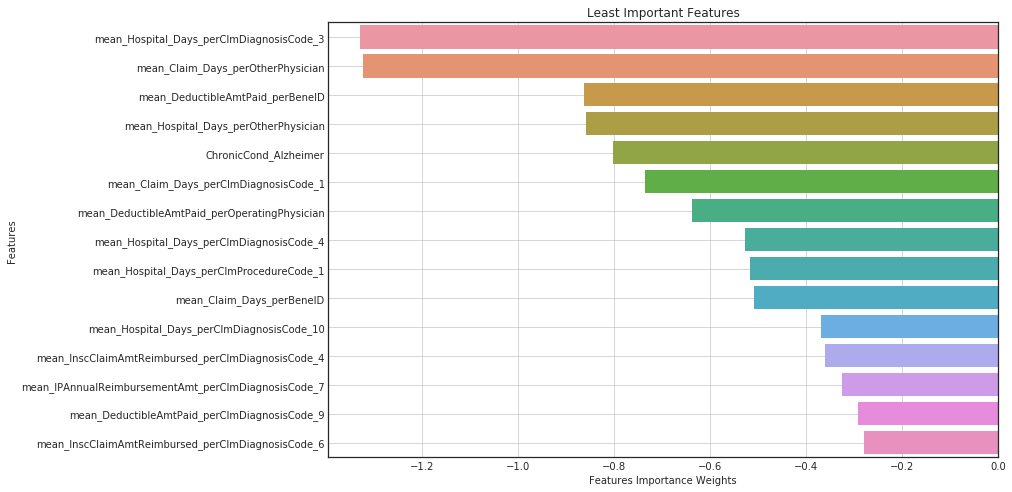

In [6]:
imp_features(imp_feat, feat_weights, True, 'Least Important ')             # function call

#### 3.4.3 Summary of results 

In [7]:
data = PrettyTable(['Model', 'Sampling Ratio', 'Solution for Imbalanced Data', 'Train AUC', 'CV AUC', 'Train F1 Score', 'CV F1 Score', 'False Negatives'])
data.add_row(['Logistic Regression', '70:30', 'Class Weight = Balanced', 0.9406, 0.9532, 0.5751, 0.6044, 16])

print(data)

+---------------------+----------------+------------------------------+-----------+--------+----------------+-------------+-----------------+
|        Model        | Sampling Ratio | Solution for Imbalanced Data | Train AUC | CV AUC | Train F1 Score | CV F1 Score | False Negatives |
+---------------------+----------------+------------------------------+-----------+--------+----------------+-------------+-----------------+
| Logistic Regression |     70:30      |   Class Weight = Balanced    |   0.9406  | 0.9532 |     0.5751     |    0.6044   |        16       |
+---------------------+----------------+------------------------------+-----------+--------+----------------+-------------+-----------------+


## 4. Store the best model as .pkl file

In [8]:
import joblib

model3.feature_names = list(X_train_std.columns.values)
joblib.dump(model3, 'best_model.pkl')

['best_model.pkl']

## 5. Conclusion from Best Model

1. It can be concluded that <b>Logistic Regression with 70:30 split is the best performing model with random state =49</b>.
2. The <u>model performance</u> for <b>Logistic Regression</b> with <b>Class Weight = Balanced, random state = 49 and 70:30 train test split</b> is as follows:
<ol type = 'i'>
<li>The <b>CV AUC score is 0.9532</b>.</li>
<li>The <b>CV F1 score is 0.6044</b>.</li>
<li>The number of <b>false negatives</b> is <b>16</b>.</li>
</ol>
3. Because of the <b>best CV AUC and CV F1 Score</b>, <u>Logistic Regression with random state = 49 is preferred as the best model</u>.
4. The following aggregated features are <b>useful</b> in achieving good model performance:
<ol type = 'a'>
<li>Attending Physician</li> 
<li>Operating Physician</li>
<li>Other Physician</li>
<li>Hospitalization Days</li>
<li>Provider</li>
<li>Claim Days</li>
<li>Beneficiary ID</li>
<li>Renal Disease Indicator</li>
<li>Diagnostic Codes(2,4,5,8,9)</li> 
<li>Race_3</li>
<li>Insurance Claim Reimbursement Amount</li>
</ol>
5. The above mentioned Aggregated features(that capture the interactions b/w the different parties involved in the <b>Claim</b> process have certainly helped in achieving the <b>good performance scores</b>.